In [71]:
%load_ext autoreload
%autoreload 2
import pathlib
import matplotlib
from matplotlib import pyplot as plt
import scipy 
import numpy as np
import os
from iscat.karitro import particles as particles_mod
from iscat.karitro import simple_api, particle_calibration, illumination_map, illumination_edges, sweep_source
from iscat.karitro.file_io import mpk_reader, spec
from utils import colours, contourPlotNew, scatterPlotKDE, histPlot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
# Configure plotting style
matplotlib.rcParams["axes.prop_cycle"] = matplotlib.cycler(
    color=[c.rgba() for c in colours.DEFAULT_HISTOGRAM_COLOUR_LIST]
)
%matplotlib inline

In [65]:
#Load the data , Enter the path
data_path = pathlib.Path(r"F:\22-6-2023 test data V5 board")
mpks = [p for p in data_path.iterdir() if p.suffix == ".mpk"]
mpks

[WindowsPath('F:/22-6-2023 test data V5 board/001_5BM.mpk'),
 WindowsPath('F:/22-6-2023 test data V5 board/002_5BM.mpk'),
 WindowsPath('F:/22-6-2023 test data V5 board/003_80s.mpk'),
 WindowsPath('F:/22-6-2023 test data V5 board/004_av.mpk'),
 WindowsPath('F:/22-6-2023 test data V5 board/005_av.mpk'),
 WindowsPath('F:/22-6-2023 test data V5 board/006_av.mpk'),
 WindowsPath('F:/22-6-2023 test data V5 board/007_av.mpk')]

In [66]:
#Analyze the data and save them in csv format
particles_dict = {}
for mpk in mpks:
    filepath_csv = pathlib.Path(mpk.parent / f"{mpk.stem}.csv")
    if not filepath_csv.is_file():
        particles = simple_api.analyse_from_path(mpk)
        particles_mod.save_particles_to_csv(particles, filepath_csv)
        particles_dict[mpk] = particles
    else:
        particles_dict[mpk] = particles_mod.load_particles_from_csv(filepath_csv)
        

Text(0.5, 1.0, '002_5BM.mpk')

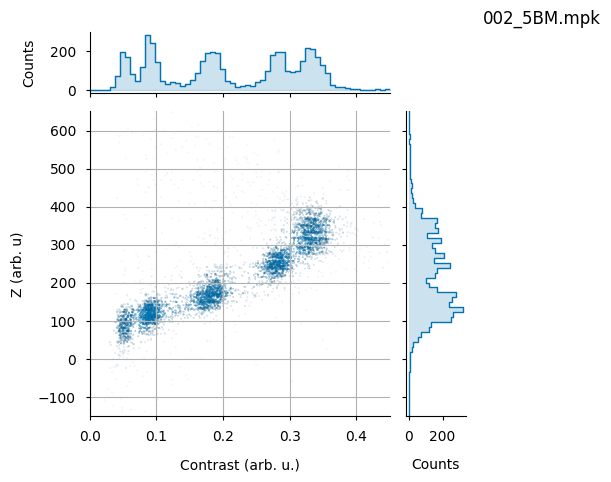

In [67]:
# Select the data that you want to plot (uncalibrated)
filename= "002_5BM.mpk"

full_path=os.path.join(data_path, filename)
ind=mpks.index(pathlib.Path(full_path))
dataset=particles_dict[mpks[ind]] 
contrast=dataset.contrast
z=dataset.z*1e9
hp = scatterPlotKDE.ScatterPlotKDE([-150,650],[0,0.45],13)
hp.plot(contrast,z)
hp._axMain.set_ylabel('Z (arb. u)', labelpad=10)
hp._axMain.grid(open)
plt.title(filename)

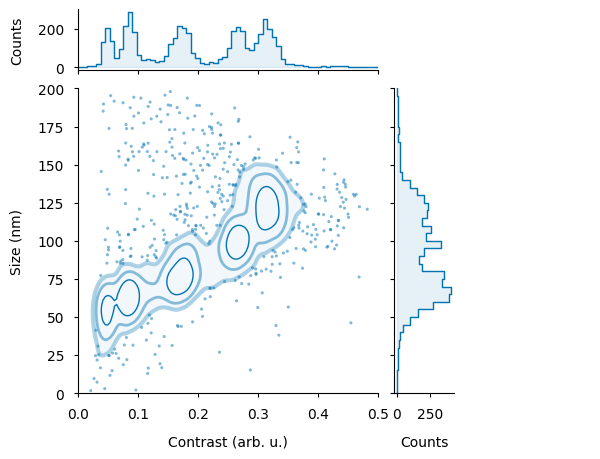

In [68]:
#calibrate and plot 2D calibrated data (only for beads mix)
fit = particle_calibration.Fit.from_particles(dataset)
calibrated_particles = fit.calibrate_particles(dataset)
cp = contourPlotNew.ContourPlot([0.1,0.2,0.5])
cp.figure
cp.plot(calibrated_particles.contrast, calibrated_particles.z)

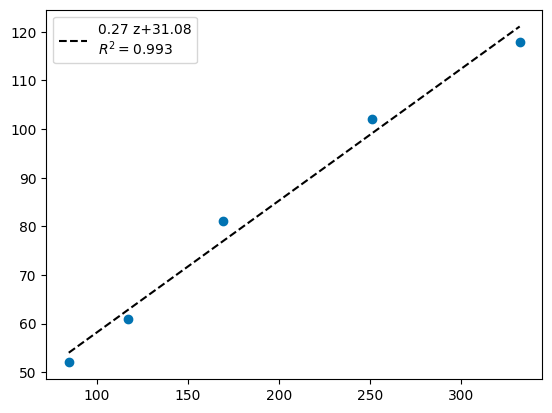

In [69]:
m=fit.result.size_gradient
b=fit.result.size_intercept
y=m*fit.beads_z_raw+b
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(fit.beads_z_raw*1e9, fit.standard.tem_sizes_nm)
plt.plot(fit.beads_z_raw*1e9,y,'k--',label=str(np.round(fit.result.size_gradient*1e-9,2))+' z'+'+'+str(np.round(fit.result.size_intercept,2))+'\n'+'$R^2=$'+str(round(r_value,4)))
plt.scatter(fit.beads_z_raw*1e9,fit.standard.tem_sizes_nm)
plt.legend()

Text(0.5, 1.0, '002_5BM.mpk')

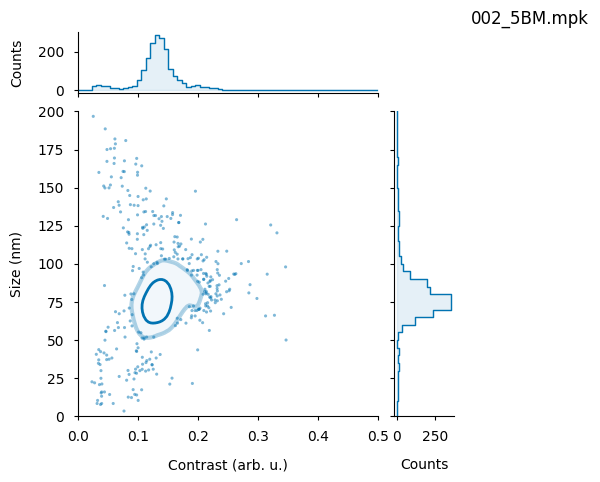

In [113]:
#Apply the calibration to a dataset
filename_s= "003_80s.mpk"

full_path_s=os.path.join(data_path, filename_s)
ind=mpks.index(pathlib.Path(full_path_s))
dataset_s=particles_dict[mpks[ind]] 
calibrated_particles_s = fit.calibrate_particles(dataset_s)
cp.figure
cp = contourPlotNew.ContourPlot([0.2,0.5])
cp.plot(calibrated_particles_s.contrast, calibrated_particles_s.z)
plt.title(filename)


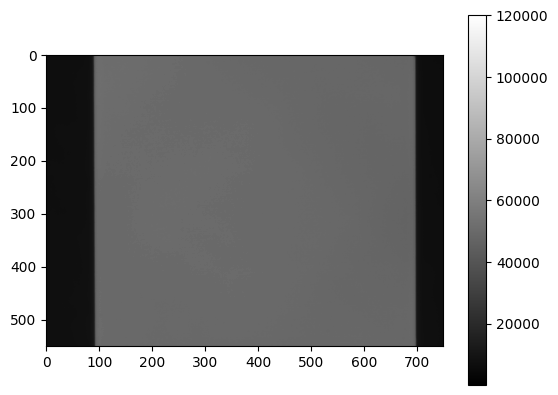

In [126]:
#calculate the illumination profile
%matplotlib inline
data_path = pathlib.Path(r"F:\22-6-2023 test data V5 board\003_80s.mpk")
sweep_s=sweep_source.path_to_sweep_source(data_path)
illumination1=illumination_map.illumination_map_from_buffer_z_sweeps(sweep_s)
plt.imshow(illumination1,cmap='gray',vmin=100,vmax=120000)
plt.colorbar()
plt.savefig(r'D:\test\illumination.png', transparent=False, dpi=300,bbox_inches='tight')

In [7]:
import hyperspy.api as hs

In [127]:
#illumination variation accross the FoV
%matplotlib qt
im0=hs.load(r'D:\test\illumination.png')
im0.plot()
line_profile = hs.roi.Line2DROI(400, 650, 320, 500,linewidth=15)
line0 = line_profile.interactive(im0)
ssum_mean = hs.interactive(line0.mean, axis=0)
# Obtain the signals to plot by "slicing" the signals with the ROI
hs.plot.plot_spectra([line0],auto_update=True)


<Axes: xlabel='<undefined> (<undefined>)', ylabel='Intensity'>